# PROJECT
# development of a machine learning model for predicting customer churn for a telecommunications company

## Formulation of the problem

The telecom operator **Niedinogorazryva.com** wants to learn how to predict customer outflow.

If it turns out that the user is planning to leave, they will be offered promotional codes and special conditions.

Historical data available, incl. personal data about some clients, information about their tariffs and contracts.

**Description of services**

The operator provides two main types of services:

- Landline telephone connection. It is possible to connect a telephone set to several lines simultaneously.
- Internet. The connection can be of two types: via a telephone line (DSL, from the English digital subscriber line, “digital subscriber line”) or fiber optic cable (Fiber optic).

The following services are also available:

Internet security: antivirus (DeviceProtection) and blocking of unsafe sites (OnlineSecurity);

Dedicated technical support line (TechSupport);

Cloud file storage for data backup (OnlineBackup);

Streaming television (StreamingTV) and movie catalog (StreamingMovies).

Clients can pay for services every month or sign a contract for 1–2 years. Various payment methods and the ability to receive an electronic receipt are available.

**Description of data**

The data is presented in 4 tables:

- contract_new.csv — information about the contract;
- personal_new.csv — client’s personal data;
- internet_new.csv — information about Internet services;
- phone_new.csv — information about telephony services.

In all files, the customerID column contains the customer ID.


The data is located in the /datasets/ folder.

Information about contracts is current as of **01 February 2020**.

**Formulation of the problem**

It is necessary to form a machine learning model that predicts, based on historical data, whether a customer plans to leave or not. Those. it is necessary to solve **classification problem, supervised learning**. Train a model that determines the client’s desire to refuse the company’s services in order not to lose him and promptly offer promotional codes and special conditions.

Quality metric of the resulting model: **AUC-ROC**

Required metric value: **more than 0.85**.

## Project Execution Plan

**1. Pre-processing and exploratory data analysis**
- Loading data from files
- Combining data into one dataset
- Data preprocessing
- Bringing data to correct formats
- Filling in the blanks
- Study of anomalies
- Study of correlation between data
- Elimination of redundant data

**2. Preparing data for training models and training multiple models**
- Dividing the data into training and test samples, in a ratio of 3:1
- Coding of features: categorical and numeric
- Training of several models (at least 3) with selection of the best hyperparameters
- Selecting the best model on the training set
- Checking the best model on a test sample

**3. Generation of the final report**
- Summarizing data on the completed project and formulating the final conclusion, incl. study of the importance of features and the formation and interpretation of an error matrix
- Indication of the best model with its hyperparameters
- List of features on which the model was trained.

## Pre-processing and exploratory data analysis

In [ ]:
pip install phik

     |████████████████████████████████| 679 kB 1.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import phik
import re

import seaborn as sns
import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix

from functools import reduce

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split as tts

from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.metrics import accuracy_score as acc

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

Loading data from files:

In [ ]:
df_c = pd.read_csv('/datasets/contract_new.csv', index_col = 'customerID', parse_dates = ['BeginDate', 'EndDate'])
df_pd = pd.read_csv('/datasets/personal_new.csv', index_col = 'customerID')
df_int = pd.read_csv('/datasets/internet_new.csv', index_col = 'customerID')
df_phone = pd.read_csv('/datasets/phone_new.csv', index_col = 'customerID')

### Data overview

We create a data review function from downloaded files

In [ ]:
def df_info(df):
    df.info()
    print()
    display(df.shape)
    print()
    display(df.describe())
    print()
    display(df.head(10))

**Dataset overview 'contract'**

In [ ]:
df_info(df_c)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB



(7043, 7)

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68


The 'EndDate' column was loaded with the 'object' type because... it contains 'No' values, implying that the client is still a client; to work with this column in the future, it will be necessary to replace this value with a date. Considering that the date of data upload (=data actuality date) = 02/01/2020, in the future, we will replace the value 'No' with this date.
The 'TotalCharges' column is also loaded with type 'object', you will need to convert it to type 'float64' later.
There are no gaps in the data.

**Dataset overview 'personal'**

In [ ]:
df_info(df_pd)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB



(7043, 4)

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
9305-CDSKC,Female,0,No,No
1452-KIOVK,Male,0,No,Yes
6713-OKOMC,Female,0,No,No
7892-POOKP,Female,0,Yes,No


The number of lines in 'personal' is the same as the number of lines in 'contract', i.e. Contract data is provided for all clients. There are no gaps in the data. At first glance, the information in 'personal' does not need to be adjusted/transformed.

**Dataset overview 'internet'**

In [ ]:
df_info(df_int)

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB



(5517, 7)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,DSL,Yes,No,No,No,No,No
7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


The number of lines in 'internet' is less than in 'contract' and 'personal', therefore not all clients use the Internet service.
There are no gaps in the data.
At first glance, the data on the 'internet' does not need to be adjusted/transformed.

**Dataset overview 'phone'**

In [ ]:
df_info(df_phone)

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB



(6361, 1)

,MultipleLines
count,6361
unique,2
top,No
freq,3390


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
7892-POOKP,Yes
6388-TABGU,No
9763-GRSKD,No
7469-LKBCI,No


The number of lines in 'phone' is less than in 'contract' and 'personal', therefore not all clients use the Internet service, but more than in 'internet', therefore some clients use both Internet and telephone services. There are no gaps in the data. At first glance, the data on the 'internet' does not need to be adjusted/transformed.

### Combining data into one dataset

We will combine the data using a common characteristic for all tables: **customerID**

In [ ]:
df_full = reduce(lambda left,right: pd.merge(left, right, on=['customerID'], how='outer'),
              [df_c, df_pd, df_int, df_phone])

df_info(df_full)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBackup      5517 non-null   object        
 14  DeviceProtecti

(7043, 19)

,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes


After merging the data, it is necessary to transform the data in the 'EndDate' column - exclude 'No', replacing it with the date of relevance of the data = 02/01/2020 and fill in the gaps in the columns, starting with 'InternetService'. Because All these columns are categorical, describing the types of services that the client uses, then the absence of data in these columns is equivalent to the value 'No'.

Let's perform these transformations.

### Converting Column Data

Let's check how many rows already contain the value '02/01/2020' in the column 'EndDate'

In [ ]:
end_date_count = len(df_full[df_full['EndDate'] == '2020-02-01'])
end_date_count

0

Before the transformation, the 'EndDate' column does not contain the date 02/01/2020, which means replacing 'No' with this date will not affect the quality of the data in this column and its statistical characteristics.

In [ ]:
df_full['EndDate'] = df_full['EndDate'].replace('No', '2020-02-01')

The task of the project is to determine whether the client will remain a client or leave, therefore it is necessary to form a target category attribute based on the value in the 'EndDate' column - all values except 02/01/2020 will be leveled to 0, and 02/01/2020 to 1. Thus. 0 means that the client has left, and 1 that it is still an active client.

In [ ]:
def target(date):
    if date == '2020-02-01':
        return 1
    else:
        return 0
df_full['target'] = df_full['EndDate'].apply(target)

Convert 'EndDate' to format datetime

In [ ]:
df_full['EndDate'] = pd.to_datetime(df_full['EndDate'])

Let's add a column for the period during which the client is a client. We calculate it as the difference (in days) between 'BeginDate' и 'EndDate'.

In [ ]:
df_full['client_period'] = (df_full['EndDate'] - df_full['BeginDate']).dt.days

When completing date conversions, let's delete the 'BeginDate' and 'EndDate' columns, because a column has already been added instead 'client_period'.

In [ ]:
df_full.drop(['EndDate', 'BeginDate'], axis=1, inplace=True)

In [ ]:
df_full.head(10)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,client_period
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,1,31
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,123
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,153
9305-CDSKC,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,1,337
1452-KIOVK,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,1,671
6713-OKOMC,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN,1,306
7892-POOKP,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,1,945


### Filling in the blanks

Let's fill in the data gaps by replacing them with 'No'.

In [ ]:
df_full = df_full.fillna('No')

### Removing duplicate rows

Let's check for complete explicit duplicate rows

In [ ]:
df_full.duplicated().sum()

4

Let's remove duplicates

In [ ]:
df_full = df_full.drop_duplicates()

### Changing data types in columns

In [ ]:
df_full.loc[df_full['TotalCharges'] == ' ', 'TotalCharges'] = 0

df_full['TotalCharges'] = pd.to_numeric(df_full['TotalCharges'])

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7039 non-null   object 
 1   PaperlessBilling  7039 non-null   object 
 2   PaymentMethod     7039 non-null   object 
 3   MonthlyCharges    7039 non-null   float64
 4   TotalCharges      7039 non-null   float64
 5   gender            7039 non-null   object 
 6   SeniorCitizen     7039 non-null   int64  
 7   Partner           7039 non-null   object 
 8   Dependents        7039 non-null   object 
 9   InternetService   7039 non-null   object 
 10  OnlineSecurity    7039 non-null   object 
 11  OnlineBackup      7039 non-null   object 
 12  DeviceProtection  7039 non-null   object 
 13  TechSupport       7039 non-null   object 
 14  StreamingTV       7039 non-null   object 
 15  StreamingMovies   7039 non-null   object 
 16  MultipleLines     7039 non-null 

### Exploring the correlation between columns of data

In [ ]:
df_full_features = df_full.copy()
df_full_features.drop(['target'],axis=1,inplace=True)

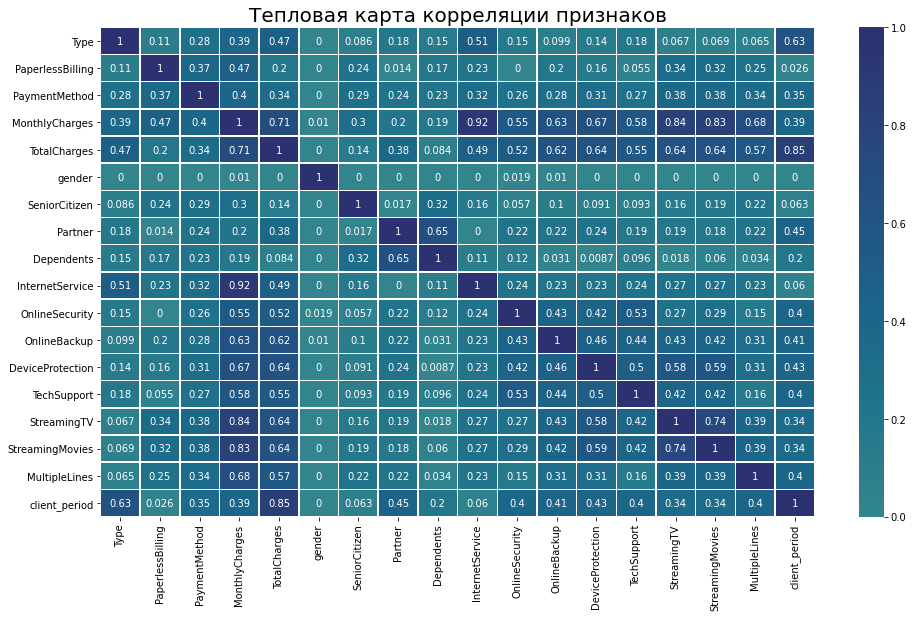

In [ ]:
corr_matrix = df_full_features.phik_matrix(interval_cols=['MonthlyCharges','client_period','TotalCharges', 'SeniorCitizen'])

fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(corr_matrix, annot=True, cmap='crest', linewidths=0.5, ax=ax, center=0)
ax.set_title('Тепловая карта корреляции признаков', fontsize=20);

The correlation heat map shows a relationship between the data in the 'InternetService' and 'MonthlyCharges' columns. Correlation coefficient value = 0.92. Despite this, we will not rule out any of these signs.

### Converting column names to snake style

At the end of the preprocessing stage, we convert the column names to “snake case”.

In [ ]:
def snake_column_name (column_name):
    mask = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    snake_column_name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', mask).lower()
    return snake_column_name

def re_name (df):
    new_names = []
    for column in df.columns:
        new_name = snake_column_name(column)
        new_names.append(new_name)
    df.columns = new_names
    return df

df_full_features = re_name(df_full_features)

### Results of preprocessing

In [ ]:
df_full_features=df_full_features.astype({'senior_citizen':object})

In [ ]:
df_full_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7039 non-null   object 
 1   paperless_billing  7039 non-null   object 
 2   payment_method     7039 non-null   object 
 3   monthly_charges    7039 non-null   float64
 4   total_charges      7039 non-null   float64
 5   gender             7039 non-null   object 
 6   senior_citizen     7039 non-null   object 
 7   partner            7039 non-null   object 
 8   dependents         7039 non-null   object 
 9   internet_service   7039 non-null   object 
 10  online_security    7039 non-null   object 
 11  online_backup      7039 non-null   object 
 12  device_protection  7039 non-null   object 
 13  tech_support       7039 non-null   object 
 14  streaming_tv       7039 non-null   object 
 15  streaming_movies   7039 non-null   object 
 16  multiple_lines

Intermediate conclusion for the section.

After preprocessing, the data is ready to form samples (training and testing), on which various machine learning models will be trained.

## Model training and selection of the best model

### Dividing samples into training and testing

In [ ]:
RANDOM_STATE = 280823

In [ ]:
features = df_full_features
target   = df_full['target']

numeric_features  = ['monthly_charges', 'total_charges', 'client_period']
category_features = features.drop(['monthly_charges', 'total_charges','client_period'], axis=1).columns.tolist()

features_train, features_test, target_train, target_test = tts(features, target, test_size=0.25, random_state=RANDOM_STATE)

Checking the ratio of dimensions of training and test samples

In [ ]:
category_features

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [ ]:
features_train['type'].unique()

array(['One year', 'Month-to-month', 'Two year'], dtype=object)

In [ ]:
features_train['paperless_billing'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
features_train['payment_method'].unique()

array(['Bank transfer (automatic)', 'Mailed check', 'Electronic check',
       'Credit card (automatic)'], dtype=object)

In [ ]:
features_train['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [ ]:
features_train['senior_citizen'].unique()

array([0, 1], dtype=object)

In [ ]:
features_train['partner'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
features_train['dependents'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
features_train['internet_service'].unique()

array(['Fiber optic', 'No', 'DSL'], dtype=object)

In [ ]:
features_train['online_security'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
features_train['online_backup'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
features_train['device_protection'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
features_train['streaming_tv'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
features_train['streaming_movies'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
features_train['multiple_lines'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
features_train.shape

(5279, 18)

In [ ]:
features_test.shape

(1760, 18)

In [ ]:
print(round(features_train.shape[0]/features_test.shape[0],2))

3.0


In [ ]:
target_train.shape

(5279,)

In [ ]:
target_test.shape

(1760,)

In [ ]:
print(round(target_train.shape[0]/target_test.shape[0],2))

3.0


The division of data into training and test samples was performed correctly, in the required ratio of 3:1.

### Model training LogisticRegression

In [ ]:
numeric_scaler = StandardScaler()
category_encoder_lr = OneHotEncoder(handle_unknown='error', drop='first')

In [ ]:
transform_lr = ColumnTransformer(transformers=[('num', numeric_scaler, numeric_features),
                                               ('cat', category_encoder_lr, category_features)])

In [ ]:
pipe_line_lr = Pipeline(steps=[
    ('preprocessor', transform_lr),
    ('feature_selection', SelectFromModel(LogisticRegression(random_state=RANDOM_STATE), threshold=0.05)),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))])

model_lr_parametrs = {'classifier__C': [0.1, 0.5, 1.0, 1.5,2.0],
                      'classifier__penalty': ['l1', 'l2'],
                      'classifier__solver': ['liblinear']}

In [ ]:
model_lr = GridSearchCV(pipe_line_lr,
                        model_lr_parametrs,
                        cv=5,
                        scoring='roc_auc',
                        n_jobs=-1)

In [ ]:
model_lr.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'client_period']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                          

In [ ]:
print('Лучшие гиперпараметры: ', model_lr.best_params_)
print('Лучшее значение метрики ROC-AUC: ', round(model_lr.best_score_,3))

Лучшие гиперпараметры:  {'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Лучшее значение метрики ROC-AUC:  0.769


### Model training RandomForestClassifier

In [ ]:
numeric_scaler   = StandardScaler()
category_encoder = OneHotEncoder(handle_unknown='ignore')

In [ ]:
transform_rfc = ColumnTransformer(transformers=[('num', numeric_scaler, numeric_features),
                                                ('cat', category_encoder, category_features)])

In [ ]:
pipe_line_rfc = Pipeline(steps=[
    ('preprocessor', transform_rfc),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=RANDOM_STATE), threshold=0.05)),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))])

model_rfc_parametrs = {'classifier__n_estimators': range(100, 601, 250),
                       'classifier__max_depth': range(1, 27, 5),
                       'classifier__min_samples_split': [2, 10, 20],
                       'classifier__min_samples_leaf': [1, 2] }

In [ ]:
model_rfc = GridSearchCV(pipe_line_rfc,
                         model_rfc_parametrs,
                         cv=5,
                         scoring='roc_auc',
                         n_jobs=-1)

In [ ]:
model_rfc.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'client_period']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
               

In [ ]:
print('Лучшие гиперпараметры: ', model_rfc.best_params_)
print('Лучшее значение метрики ROC-AUC: ', round(model_rfc.best_score_,3))

Лучшие гиперпараметры:  {'classifier__max_depth': 16, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 20, 'classifier__n_estimators': 350}
Лучшее значение метрики ROC-AUC:  0.808


### Model training CatBoostClassifier

In [ ]:
features_train[category_features] = features_train[category_features].astype('category')

In [ ]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5279 entries, 9909-DFRJA to 5712-AHQNN
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               5279 non-null   category
 1   paperless_billing  5279 non-null   category
 2   payment_method     5279 non-null   category
 3   monthly_charges    5279 non-null   float64 
 4   total_charges      5279 non-null   float64 
 5   gender             5279 non-null   category
 6   senior_citizen     5279 non-null   category
 7   partner            5279 non-null   category
 8   dependents         5279 non-null   category
 9   internet_service   5279 non-null   category
 10  online_security    5279 non-null   category
 11  online_backup      5279 non-null   category
 12  device_protection  5279 non-null   category
 13  tech_support       5279 non-null   category
 14  streaming_tv       5279 non-null   category
 15  streaming_movies   5279 non-null   category
 

In [ ]:
category_features

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [ ]:
pipe_line_cbc = Pipeline(steps=[
    ('feature_selection', SelectFromModel(CatBoostClassifier(random_state=RANDOM_STATE,
                                                             cat_features=[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16],
                                                             verbose=False),
                                          threshold=0.05)),
    ('classifier', CatBoostClassifier(random_state=RANDOM_STATE,
                                      verbose=False,
                                      cat_features=[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16]))
])

In [ ]:
model_cbc_parametrs = {
                       'classifier__iterations': [1000, 1500, 2000],
                       'classifier__learning_rate': [0.03, 0.1],
                       'classifier__depth': [4, 6],
                       'classifier__l2_leaf_reg': [1, 3]
                      }

model_cbc = GridSearchCV(pipe_line_cbc,
                         model_cbc_parametrs,
                         cv=5,
                         error_score='raise',
                         scoring='roc_auc',
                         n_jobs=-1)

In [ ]:
model_cbc.fit(features_train, target_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectFromModel(estimator=<catboost.core.CatBoostClassifier object at 0x7f6db30d0880>,
                                                        threshold=0.05)),
                                       ('classifier',
                                        <catboost.core.CatBoostClassifier object at 0x7f6db30d0dc0>)]),
             n_jobs=-1,
             param_grid={'classifier__depth': [4, 6],
                         'classifier__iterations': [1000, 1500, 2000],
                         'classifier__l2_leaf_reg': [1, 3],
                         'classifier__learning_rate': [0.03, 0.1]},
             scoring='roc_auc')

In [ ]:
print('Лучшие гиперпараметры: ', model_cbc.best_params_)
print('Лучшее значение метрики ROC-AUC: ', round(model_cbc.best_score_,3))

Лучшие гиперпараметры:  {'classifier__depth': 4, 'classifier__iterations': 1000, 'classifier__l2_leaf_reg': 1, 'classifier__learning_rate': 0.1}
Лучшее значение метрики ROC-AUC:  0.925


### Checking the best model on a test set

In [ ]:
model = model_cbc.best_estimator_

model_pred  = model.predict_proba(features_test)
model_score = roc_auc(target_test, model_pred[:, 1])

In [ ]:
print('Значение метрики \'ROC-AUC\' на тестовой выборке: ', round(model_score,3))

Значение метрики 'ROC-AUC' на тестовой выборке:  0.917


The best model on the test sample showed a **ROC-AUC metric value of 91.7%**, which is higher than the required value (85%) determined when setting the problem.

Thus, the task has been completed: the model has been selected (**CatBoostClassifier**) and hyperparameters have been selected for it, giving the best value for the roc-auc metric.

### Error matrix of the best model

In [ ]:
model_pred  = model.predict(features_test)

confusion_matrix = confusion_matrix(target_test, model_pred)

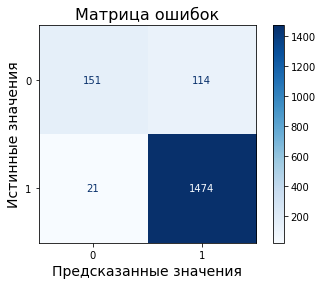

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=model.classes_)

disp.plot(cmap='Blues')

plt.title ('Матрица ошибок', fontsize=16)
plt.ylabel('Истинные значения', fontsize=14)
plt.xlabel('Предсказанные значения', fontsize=14);

Of the available 1,760 objects in the test sample, the model correctly predicted 1,625 (1,474 - 1/1 and 151 - 0/0). Those. in more than 92% of cases the model gives the correct result.

The model is very good at predicting customers who will stay with the company, here the accuracy of the model is more than 98.5% (1,474 / 1,495).

For a large proportion of 43% (114 / 265) clients who left, the model predicts that the client will remain. This indicator, without taking into account the total number of objects in the test sample, may seem significant, however, if we evaluate the final value of the model error - less than 8% ((21+114) / 1,760), then we can consider that the model successfully copes with the task, significantly exceeding the minimum specified accuracy of 85%.

### Feature significance analysis

In [ ]:
features_names = features.columns.tolist()
features_importances = model.named_steps['classifier'].feature_importances_

features_importance = pd.DataFrame({'Признак': features_names,
                                    'Значимость': features_importances}).sort_values(by='Значимость', ascending=False)

features_importance

,Признак,Значимость
17,client_period,54.704242
4,total_charges,11.595487
3,monthly_charges,9.774656
0,type,6.792472
2,payment_method,3.446375
7,partner,2.624335
9,internet_service,2.093089
16,multiple_lines,1.715298
11,online_backup,1.483644
12,device_protection,1.017820


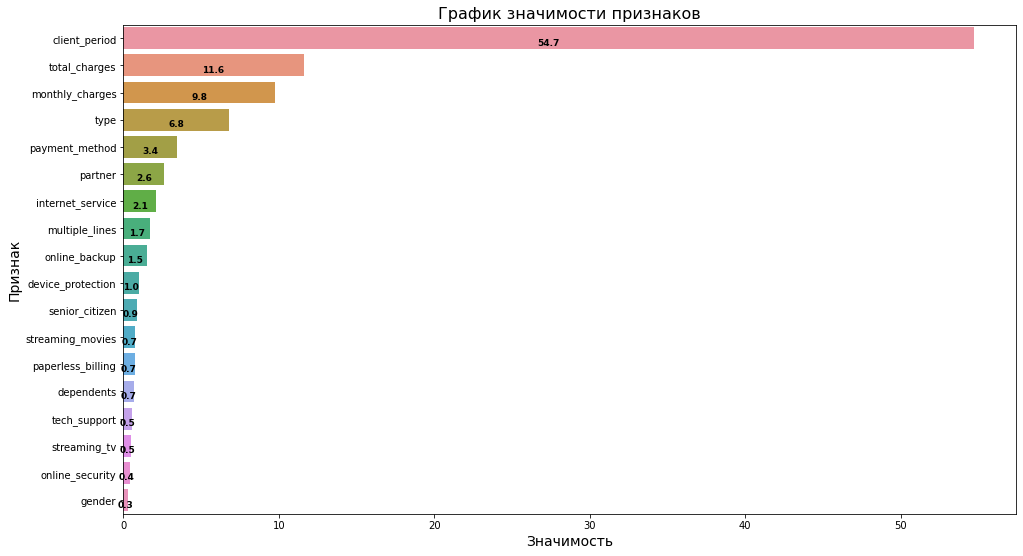

In [ ]:
plt.figure(figsize=(16, 9))
ax = sns.barplot(x='Значимость', y='Признак', data=features_importance, orient='h')
ax.set_xlabel('Значимость', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)
ax.set_title('График значимости признаков', fontsize=16)

for i, v in enumerate(features_importance['Значимость']):
     ax.text(v/2, i + .25, str(round(v, 1)), color='black', fontweight='bold', ha='center', fontsize=9);

Of the **18** features on which the model was trained, the main influence is exerted by the **'client_period'** feature - the period during which the client uses the company's services. Next in order of importance are the signs with the size of total (**'total_charges'**) and monthly payments (**'monthly_charges'**) and payment types.

The total importance of the **7** most important features is **91%**.


**The least influence** on the model is characterized by the attributes 'gender', 'online_security', 'streaming_tv', 'tech_support', 'dependents'. Their combined influence on the model is **only 2.4%**.

**OUTPUT by section:**

As a result of performing the selection of the best model, based on the roc-auc metric, the **CatBoostClassifier** model was selected. The remaining models considered (LogisticRegression and RandomForestClassifier) give the worst results in terms of quality metrics.

For the best model, the best hyperparameters were selected to maximize the quality metric.

The best hyperparameters for the selected model are:
- 'classifier__depth': 4,
- 'classifier__iterations': 1000,
- 'classifier__l2_leaf_reg': 1,
- 'classifier__learning_rate': 0.1

The best model was tested on a test sample and showed a quality metric value of **91.7%**.

The importance of the features was analyzed and the most important features (client_period, total_charges, monthly_charges) and the least important ('gender', 'online_security', 'streaming_tv', 'tech_support', 'dependents') were identified.
It was found that the importance of the first three signs is 76.1%, and the last 5 - 2.4%.

## PROJECT REPORT

### Project goals and objectives

**Objective of the project:**

To create a machine learning model for the customer - telecom operator **"Niedinogazryva.com"**, which predicts, based on historical data, whether the client plans to leave or not.

**Project objectives:**

- Solve **classification problem, supervised learning**.
- Train a model that determines the client’s desire to refuse the company’s services.
- The trained model must have a quality metric score **AUC-ROC** of at least **0.85**.

### Project execution plan:


**1. Pre-processing and exploratory data analysis**
- Loading data from files
- Combining data into one dataset
- Data preprocessing
- Bringing data to correct formats
- Filling in the blanks
- Study of anomalies
- Study of correlation between data
- Elimination of redundant data

**2. Preparing data for training models and training multiple models**
- Dividing the data into training and test samples, in a ratio of 3:1
- Coding of features: categorical and numeric
- Training of several models (at least 3) with selection of the best hyperparameters
- Selecting the best model on the training set
- Checking the best model on a test sample

**3. Generation of the final report**
- Summarizing data on the completed project and formulating the final conclusion, incl. study of the importance of features and the formation and interpretation of an error matrix
- Indication of the best model with its hyperparameters
- List of features on which the model was trained.

**During the implementation of the project, the plan was fully implemented; no adjustments to the plan based on actual actions had to be made.**

### Description of the main steps actually performed when working on the project:

- The data was loaded from 4 different files into 4 variables. Already during the loading process, an attempt was made to load date data into datetime format.
- A review of the data loaded from each file was performed.
- The data was merged into 1 file (merge(left, right, on=['customerID'], how='outer')).
- Obvious complete duplicate lines have been removed, gaps have been filled in (with the value "No").
- Based on data about the beginning (BeginDate) and end (EndDate) of the contractual relationship with the client, two additional characteristics were created: - the period ("client_period") during which the client is (was) a client and the target characteristic ("target") is cb rkbtyn rkbtynjv (1) or the client is no longer a client (0). After which the BeginDate and EndDate columns were removed from the characteristics, because no longer provide value for model training;
- Data are reduced to the required formats - numeric attributes to float and int formats, and categorical attributes to object;
- The correlation between signs has been studied. It was found that the characteristics InternetService and MonthlyCharges have the highest correlation, the correlation coefficient between them is 0.92;
- column names are adjusted to "snake_style".

**TOTAL, for training the models, a sample size of 7,039 rows by 18 columns was generated, of which 1 - int, 2 - float and 15 - object.**

### RESULTS of the project:

To solve the project problem, 3 machine learning models were created and trained:
- LogisticRegression;
- RandomForestClassifier;
- CatBoostClassifier.

The selection of the best hyperparameters of the models was carried out using GridSearchCV.

The results of training models with the best hyperparameters according to the roc-auc quality metric are as follows:
- LogisticRegression - 76.9%;
- RandomForestClassifier - 80.8%;
- CatBoostClassifier - 92.5%.

Thus, the best indicator in terms of quality metric was the **CatBoostClassifier** model with the following hyperparameters:
- 'classifier__depth': 4,
- 'classifier__iterations': 1000,
- 'classifier__l2_leaf_reg': 1,
- 'classifier__learning_rate': 0.1

The best model was tested on a test sample, where it showed a quality metric value of **91.7%**,

Thus, **project objectives have been fully completed**.

Also, during the project, the error matrix of the best model was analyzed and it was found that the model correctly predicts customers who remain in the company with almost 100% accuracy (98.5%) and predicts those who leave the company with worse accuracy. In general, the model copes with the task and even exceeds it (the actual metric value is significantly higher than the minimum required threshold).

In conclusion, an analysis of the importance of features was carried out, which showed that of the **18** features on which the model was trained, the main influence is exerted by the feature **'client_period'** - the period during which the client uses the company's services. Next in order of importance are the signs with the size of total (**'total_charges'**) and monthly payments (**'monthly_charges'**) and payment types. The total importance of the **7** most important features is **91%**.
**The least influence** on the model is characterized by the attributes 'gender', 'online_security', 'streaming_tv', 'tech_support', 'dependents'. Their combined influence on the model is **only 2.4%**.

**Appendix to the Project Report**

List of features on which the best model was trained:

- client_period - the period in days during which the client had a contractual relationship with the customer;
- total_charges - total subscriber expenses;
- monthly_charges - monthly expenses;
- type - type of payment: once a year or two or monthly;
- payment_method - payment type;
- partner - whether the subscriber has a spouse;
- internet_service - connection type;
- multiple_lines - connect the phone to several lines at the same time;
- online_backup - cloud file storage for data backup;
- device_protection - antivirus;
- senior_citizen - whether the subscriber is a pensioner;
- streaming_movies - movie directory;
- paperless_billing - electronic pay sheet;
- dependents - whether the subscriber has children;
- tech_support - dedicated technical support line;
- streaming_tv - streaming television;
- online_security - blocking dangerous sites;
- gender - gender.